In [2]:
from lips import get_root_path
from lips.dataset import airfransDataSet
from lips.dataset.airfransDataSet import AirfRANSDataSet
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../../Airfrans/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","simulators","torch_fc.ini") #Configuration file re
# print(BENCH_CONFIG_PATH)

# Scalers
PRESS_SCALE = 1600.0
TURB_SCALE = 0.01
SPEED_SCALE = 75.0
DEFAULT_SCALE = 1.0


In [ ]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

In [ ]:
print("train dataset: ", benchmark.train_dataset)

In [ ]:
print(benchmark.train_dataset.extra_data['simulation_names'])

In [7]:
def extract_dataset_by_simulation(newdataset_name:str,
                                   dataset:AirfRANSDataSet,
                                   simulation_index:int):
    simulation_sizes = dataset.get_simulations_sizes()
    sample_sizes = [None]*len(simulation_sizes)
    start_index = 0
    for simulation_Id,simulation_size in enumerate(simulation_sizes):
        sample_sizes[simulation_Id] = range(start_index,start_index+simulation_size)
        start_index+= simulation_size
    # values=operator.itemgetter(*list(simulation_indices))(sample_sizes)
    nodes_simulation_indices = sorted([item for sublist in [sample_sizes[simulation_index]] for item in sublist])

    new_data={}
    for data_name in dataset._attr_names:
        new_data[data_name]=dataset.data[data_name][nodes_simulation_indices]
    new_extra_data={
                    'simulation_names':dataset.extra_data['simulation_names'][simulation_index],
                    'surface':dataset.extra_data['surface'][nodes_simulation_indices]
                    }
    new_dataset=type(dataset)(config = dataset.config, 
                             name = newdataset_name,
                             task = dataset._task,
                             split = dataset._split,
                             attr_names = dataset._attr_names, 
                             attr_x = dataset._attr_x , 
                             attr_y = dataset._attr_y)

    new_dataset.data=new_data
    new_dataset.extra_data=new_extra_data
    new_dataset._infer_sizes()
    return new_dataset




In [56]:
# def translate(point, new_origin):
#     return point - new_origin

# def untranslate(point, old_origin):
#     return point + old_origin

# def project(point, line_vector):
#     return line_vector * (line_vector.dot(point) / line_vector.dot(line_vector))

# def rotate_deg(point, degrees):
#     rads = degrees * np.pi/180
#     rot_matrix = np.array([[np.cos(rads), -np.sin(rads)],[np.sin(rads), np.cos(rads)]])
#     return rot_matrix.dot(point)

def expand(vector):
    if vector.ndim == 1:
        out = np.expand_dims(vector, 0)
        return np.copy(out), True
    else:
        return np.copy(vector), False

def rotate(point, angle):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    return point.dot(rot_matrix)

def angle_between(a, b):
    if a.ndim == 1 and b.ndim == 1:
        assert(np.linalg.norm(a) > 0 and np.linalg.norm(b) > 0)
        theta = np.arccos(np.maximum(-1, np.minimum(1, a.dot(b)/np.linalg.norm(a,ord=2)/np.linalg.norm(b,ord=2))))
    else:
        assert(a.ndim == 1)
        np.seterr(all='raise')
        theta = np.arccos(np.maximum(-1, np.minimum(1, b.dot(a)/np.linalg.norm(a,ord=2)/np.linalg.norm(b, ord=2,axis=1))))
    return theta

def distance(a, b):
    return np.linalg.norm(a-b)

def relative_wind_angle(vector):
    vector, expanded = expand(vector)
    vel_theta = angle_between(np.array([1,0]), vector)
    vel_theta, _ = expand(vel_theta)
    vel_theta[np.where(vel_theta < 0)] *= -1
    if expanded:
        vel_theta = vel_theta.squeeze()
    return vel_theta

def rotate_normal(vector):
    if vector[1] <= 0: # Rotate 90 degrees counterclockwise
        out_vector = rotate(vector, -np.pi/2)
    else: #Clockwise
        out_vector = rotate(vector, np.pi/2)
    return out_vector


# def in_cone(point, origin, vector, tolerance_deg):
#     trans = translate(point, origin)
#     val = angle_between(trans, vector) <= (tolerance_deg * np.pi/360)
#     # print(val)
#     return val

# forty_five_north = np.array([-np.cos(np.pi/4), np.sin(np.pi/4)])

# print(in_cone(key_point + np.array([-.8, .7]), key_point, forty_five_north, 5))

# plt.figure()
# plt.scatter(0, 0, c='#0000DD', marker='x')
# plt.scatter(translate(test_point, key_point)[0], translate(test_point, key_point)[1], c='#0000DD', marker='o')
# plt.scatter(project(translate(test_point, key_point), forty_five_north)[0], project(translate(test_point, key_point), forty_five_north)[1], c='#0000DD', marker='x')
# plt.xlim([-1.5, 1.5])
# plt.ylim([-1.5, 1.5])
# plt.show()


In [9]:

def find_parents(idx, data, start_min, degree_list, tolerance):
    key_point = data[idx,:2] # Point of interest
    comps_mod = data[start_min:idx, :2] - key_point # Translated comparision points
    norms = comps_mod / np.expand_dims(np.linalg.norm(comps_mod, axis=1),1) # Unit vectors for comparison points

    ret_idx = []
    for degree in degree_list:
        vector = np.array([np.cos(degree * np.pi/180), np.sin(degree * np.pi/180)]) # Vector to look for parents
        thetas = np.arccos(np.maximum(-1, np.minimum(1, norms.dot(vector)))) # Find angles for all comparison points
        matching = np.argwhere(thetas <= (tolerance * np.pi/360)) # Filter by tolerance range
        c = np.atleast_1d(comps_mod[matching.squeeze(axis=1), :2].squeeze().dot(vector)) # Project onto the vector
        if(len(c) == 0): # We don't find any possible matches, then handle it
            if abs(key_point[1]) <= 1 and key_point[0] >= -1 and key_point[0] <= 2: # If we are close to the airfoil
                ret_idx.append(-2) # Close to airfoil
                continue
            else:
                ret_idx.append(-1) # Close to edge
                continue
        best = matching[np.argmin(c[np.argwhere(c>0)])] + start_min # Find index of the closest projected point
        ret_idx.append(best.item()) # Append to our return values
    return ret_idx


In [10]:

# ('x-position', 'y-position', 'x-inlet_velocity', 'y-inlet_velocity', 'distance_function', 'x-normals', 'y-normals')
# ('x-velocity', 'y-velocity', 'pressure', 'turbulent_viscosity')

# Create friendly index headers
X = 0
Y = 1
X_INLET = 2
Y_INLET = 3
DIST = 4
X_NORMAL = 5
Y_NORMAL = 6
X_VEL = 7
Y_VEL = 8
PRESS = 9
TURB = 10

def transform_x(idx, data, parents, surface, speed, theta):
    features = []
    line = data[idx, :]

    # Find closest surface point
    if line[X_NORMAL] != 0 or line[Y_NORMAL] != 0:
        closest = line
    else:
        closest = surface[np.argmin(np.linalg.norm(surface[:,:2] - line[:2], axis=1))]

    # Create modified angles and flow metrics
    surface_flow = rotate_normal(closest[X_NORMAL:Y_NORMAL+1])
    surface_theta = relative_wind_angle(surface_flow).item()

    features.append(line[X])
    features.append(line[Y])
    features.append(speed / SPEED_SCALE)
    features.append(theta)
    features.append(line[DIST])
    features.append(surface_theta)
    for parent in parents[idx]:
        if parent == -1: # Off the grid
            features.append(line[X])
            features.append(line[Y])
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(-1.0) # Off the grid specifier
        elif parent == -2: # Airfoil interior
            features.append(line[X])
            features.append(line[Y])
            features.append(0.0)
            features.append(0.0)
            features.append(surface_theta)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(0.0)
            features.append(1.0) # Interior specifier
        else:
            p = data[parent, :]
            if p[Y_NORMAL] != 0 or p[X_NORMAL] != 0: # Surface node
                features.append(p[X]) #1 X
                features.append(p[Y]) #2 Y
                features.append(0.0) #3 Distance (zero for surface)
                features.append(distance(p[X:Y+1], line[X:Y+1])) #4 Dist to parent

                p_flow = rotate_normal(p[X_NORMAL:Y_NORMAL+1])
                p_theta = relative_wind_angle(p_flow)

                features.append(p_theta) #5 Parent normal theta
                features.append(0.0) #6 Vel theta
                features.append(0.0) #7 Speed
                features.append(p[PRESS] / PRESS_SCALE) #8 Pressure
                features.append(p[TURB] / TURB_SCALE) #9 Turbulence - none for airfoil
                features.append(1.0) #10 Surface specifier
            else:
                features.append(p[X]) #1
                features.append(p[Y]) #2
                features.append(p[DIST]) #3
                features.append(distance(p[X:Y+1], line[X:Y+1])) #4

                vel_theta = relative_wind_angle(p[X_VEL:Y_VEL+1]).item()
                p_speed = np.linalg.norm(p[X_VEL:Y_VEL+1]) / SPEED_SCALE

                features.append(0.0) #5 Parent normal theta
                # features.append(vel_theta) #6 Vel theta
                # features.append(p_speed) #7 Speed
                features.append(p[X_VEL] / SPEED_SCALE)
                features.append(p[Y_VEL] / SPEED_SCALE)
                features.append(p[PRESS] / PRESS_SCALE) #8 Pressure
                features.append(p[TURB] / TURB_SCALE) #9 Turbulence
                features.append(0.0) #10 Normal specifier

    return np.array(features)


def transform_y(y_set, surface_indices):
    out, expanded = expand(y_set)
    y_set, _ = expand(y_set)
    # if True in surface_indices:
    #     out[np.array(surface_indices), 0] = 0.0
    # out[~np.array(surface_indices), 0] = relative_wind_angle(out[~np.array(surface_indices), 0:2])
    
    # out[:, 1] = np.linalg.norm(y_set[:, 0:2], axis=1) / SPEED_SCALE
    out[:, 0] /= SPEED_SCALE
    out[:, 1] /= SPEED_SCALE
    out[:, 2] /= PRESS_SCALE
    out[:, 3] /= TURB_SCALE
    if expanded:
        out = out.squeeze()
    return out

def untransform_y(y_preds):
    out, expanded = expand(y_preds)
    y_preds, _ = expand(y_preds)
    # out[:, 0] = np.cos(y_preds[:, 0]) * y_preds[:, 1] * SPEED_SCALE # X-vec * speed
    # out[:, 1] = np.sin(y_preds[:, 0]) * y_preds[:, 1] * SPEED_SCALE # X-vec * speed
    out[:, 0] *= SPEED_SCALE
    out[:, 1] *= SPEED_SCALE
    out[:, 2] *= PRESS_SCALE
    out[:, 3] *= TURB_SCALE
    if expanded:
        out = out.squeeze()
    return out



In [11]:

def extract_and_realign(dataset, sim):
    print("Simulation: " + str(sim))
    data_by_sim = extract_dataset_by_simulation("BySim", benchmark.train_dataset, sim)
    x, y = data_by_sim.extract_data()
    data = np.hstack((x, y))
    data = data[data[:, 0].argsort()]

    # Rotate data based on inlet velocity
    in_vector = np.copy(data[0,X_INLET:Y_INLET+1]) # Get inlet velocity vector
    speed = np.linalg.norm(in_vector) # Get inlet speed
    in_vector /= speed # Normalize inlet velocity vector

    # theta = np.arccos(np.maximum(-1, np.minimum(1,np.array([1,0]).dot(in_vector)))) # Wind theta
    # if(in_vector[1] < 0): # Rotate counterclockwise if y_vector below 0
    #     theta = -theta
    theta = 0.0

    data[:,:2] = rotate(data[:,:2], theta)
    data[:,X_NORMAL:Y_NORMAL+1] = rotate(data[:,X_NORMAL:Y_NORMAL+1], theta)
    data[:,X_VEL:Y_VEL+1] = rotate(data[:,X_VEL:Y_VEL+1], theta) # Now have rotated velocity vectors 

    return data, speed, theta

def identify_parents(data, sim):
    # Find parent relationships
    if os.path.exists('parents_' + str(sim) + '.npy'):
        parents = np.load('parents_' + str(sim) + '.npy')
    else:
        min_search = 0
        parents = []
        for i in tqdm(range(0, data.shape[0])):
            for m in range(min_search, i, 100):
                if data[i, 0] - data[m, 0] > .3: # Truncate search space for speed
                    min_search += 100
            parents.append(find_parents(i, data, min_search, [180, 135, 225], 5))
        np.save('parents_' + str(sim) + '.npy', np.array([np.array(xi) for xi in parents]))
    return parents

def get_surface(data):
    return data[np.where(np.logical_or(data[:,X_NORMAL] != 0.0, data[:,Y_NORMAL] != 0.0))]


In [ ]:
# Collect training examples and build features

train_x = []
train_y = []
train_x_raw = []
train_y_raw = []

def is_surface(row):
    return row[X_NORMAL] != 0.0 or row[Y_NORMAL] != 0.0

for sim in range(0, 1):    
    data, speed, theta = extract_and_realign(benchmark.train_dataset, sim)
    parents = identify_parents(data, sim)
    surface = get_surface(data)

    # Build train data
    for idx in tqdm(range(0, len(data))):
        train_x.append(transform_x(idx, data, parents, surface, speed, theta))
        # train_x_raw.append(data[idx,:])
        train_y.append(transform_y(data[idx, X_VEL:], [is_surface(data[idx])]))    
        # train_y_raw.append(data[idx, X_VEL:])

print(len(train_x))
train_x = np.vstack(train_x)
# train_x_raw = np.vstack(train_x_raw)
train_y = np.vstack(train_y)
# train_y_raw = np.vstack(train_y_raw)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class AirfoilMLP(nn.Module):
    def __init__(self, feature_count):
        super(AirfoilMLP, self).__init__()
        self.fc1 = nn.Linear(feature_count, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 4)
        self.dropout = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [ ]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

model = AirfoilMLP(train_x.shape[1])

loss_fn = torch.nn.L1Loss()
device = torch.device('cuda:0')
model.to(device)

BATCH_SIZE = 1000
LR = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(torch.float32).to(device)
        labels = labels.to(torch.float32).to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.cpu().detach().item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

training_loader = torch.utils.data.DataLoader(list(zip(train_x, train_y)), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(list(zip(test_x, test_y)), batch_size=BATCH_SIZE, shuffle=True)

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(torch.float32).to(device)
            vlabels = vlabels.to(torch.float32).to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels).cpu().detach()
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [ ]:
# Start doing progressive scan testing!
sim = 51

test_x = []
test_y = []

data, speed, theta = extract_and_realign(benchmark.train_dataset, sim)
parents = identify_parents(data, sim)
surface = get_surface(data)

# Build test data
for idx in tqdm(range(0, len(data))):
    test_x.append(transform_x(idx, data, parents, surface, speed, theta))
    test_y.append(transform_y(data[idx, X_VEL:], [is_surface(data[idx])]))
  

test_x = np.vstack(test_x)
test_y = np.vstack(test_y)
test_y_raw = data[:, X_VEL:]

In [ ]:
test_prog = []
testbed = np.copy(data)
testbed[:, X_VEL:] = 0.0
test_parents = parents

model.eval()
for idx in tqdm(range(0, testbed.shape[0])):
    # features = np.expand_dims(transform_x(idx, data, test_parents, surface, speed, theta), 0) # NOT SCANNING!!!!
    features = np.expand_dims(transform_x(idx, testbed, test_parents, surface, speed, theta), 0)

    y_pred = model.forward(torch.from_numpy(features).to(torch.float32).to(device)).cpu().detach().numpy()

    # Update testbed with new predictions so they can be used as parents
    testbed[idx, X_VEL:] = untransform_y(y_pred)
    # testbed[idx, X_VEL:] = untransform_y(np.array([pred_vel_theta, pred_speed, pred_press, pred_turb]))


In [ ]:
q = X_VEL
print(np.max(testbed[:, q]))
print(np.min(testbed[:, q]))
print(np.max(data[:, q]))
print(np.min(data[:, q]))
np.argmax(abs(testbed[:, q] - data[:, q]))

In [ ]:
print(data[42912, :])
print(testbed[42912, :])

In [ ]:
for i in range(X_VEL, TURB+1):
    print(np.sqrt(mean_squared_error(testbed[:, i], data[:, i])) / np.mean(np.abs(data[:, i])))

In [ ]:
q = PRESS

plt.figure()
errors = testbed[:, q] - data[:, q]
plt.scatter(range(0, len(testbed)), errors, s=0.1)
plt.show()

In [ ]:
print(testbed[50000, X_VEL:])
print(data[50000, X_VEL:])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize = (36, 12))
# sc0 = ax[0, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, X_VEL], s = 0.75)
# ax[0, 0].title.set_text('Velocity along x')
# plt.colorbar(sc0)
# plt.plot()
# sc1 = ax[0, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75)
sc1 = plt.scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, PRESS], s = 0.75, vmin=-750, vmax=1250)
plt.title('Pressure')
# ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
# sc2 = ax[1, 0].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, Y_VEL], s = 0.75)
# ax[1, 0].title.set_text('Velocity along y')
# plt.colorbar(sc2)
# sc3 = ax[1, 1].scatter(testbed[:, 0], testbed[:, 1], c = testbed[:, TURB], s = 0.75)
# ax[1, 1].title.set_text('Kinematic turbulent viscosity')
# plt.colorbar(sc3)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(data[:, 0], data[:, 1], c = data[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(data[:, 0], data[:, 1], c = data[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(data[:, 0], data[:, 1], c = data[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(data[:, 0], data[:, 1], c = data[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(data[:, 0], data[:, 1], c = testbed[:, X_VEL] - data[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(data[:, 0], data[:, 1], c = testbed[:, PRESS] - data[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(data[:, 0], data[:, 1], c = testbed[:, Y_VEL] - data[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(data[:, 0], data[:, 1], c = testbed[:, TURB] - data[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 1], s = 0.75)
ax[0, 1].title.set_text('y')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 2], s = 0.75)
ax[1, 0].title.set_text('p')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(train_x[:170000, 0], train_x[:170000, 1], c = train_y[:170000, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [ ]:
q = np.copy(testbed)
in_vector = q[0,X_INLET:Y_INLET+1]
speed = np.linalg.norm(in_vector)
in_vector /= speed
print(speed)
print(in_vector)
theta = np.arccos(np.maximum(-1, np.minimum(1,np.array([1,0]).dot(in_vector))))
if(in_vector[1] < 0): # Rotate clockwise if vector above 0
    theta = -theta

print(theta)

def rotate(point, angle):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    return point.dot(rot_matrix)

print(q[0,:2])
print(rotate(q[:,:2], theta))
q[:,:2] = rotate(q[:,:2], theta)
q[:,X_NORMAL:Y_NORMAL+1] = rotate(q[:,X_NORMAL:Y_NORMAL+1], theta)

surface = q[np.where(np.logical_or(q[:,X_NORMAL] != 0.0, q[:,Y_NORMAL] != 0.0))]

closest = surface[np.argmin(np.linalg.norm(surface[:,:2] - np.array([3, 0.0]), axis=1))]
closest[:2]

In [ ]:
first_ds = extract_dataset_by_simulation("BySim", benchmark.train_dataset, 0)
np.sum(first_ds.extra_data['surface'])

In [ ]:
train_y.shape

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(data[:, 0], data[:, 1], c = testbed[:, X_VEL] - data[:, X_VEL], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(data[:, 0], data[:, 1], c = testbed[:, PRESS] - data[:, PRESS], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(data[:, 0], data[:, 1], c = testbed[:, Y_VEL] - data[:, Y_VEL], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(data[:, 0], data[:, 1], c = testbed[:, TURB] - data[:, TURB], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()

In [ ]:
train_y = untransform_y(train_y)

In [ ]:


fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 1], s = 0.75)
ax[0, 1].title.set_text('y')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 2], s = 0.75)
ax[1, 0].title.set_text('p')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(train_x[:, 0], train_x[:, 1], c = train_y[:, 3], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)

scale = 0.0001
for a in [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]:
    a.set_xlim([-scale,scale])
    a.set_ylim([-scale,scale])

plt.show()

[[-5.40997689e-06 -8.93106426e-06]
 [-3.26154259e-06 -7.59439490e-06]
 [-1.26299881e-06 -6.35098195e-06]
 [-4.32940510e-07 -5.12397201e-05]
 [ 1.70361147e-06 -4.98913723e-05]
 [ 3.69110171e-06 -4.86370955e-05]
 [-1.01101405e-05  3.23641434e-05]
 [-7.94985499e-06  3.36888443e-05]
 [-5.94028688e-06  3.49211223e-05]]
[[ 1.45710995e-02 -1.26092166e-01 -1.03737809e-01  4.72364770e-09]
 [ 9.56382975e-03 -8.28355998e-02 -1.03462972e-01  4.89466512e-09]
 [ 4.77530994e-03 -4.10020687e-02 -1.03196248e-01  5.17893506e-09]
 [ 1.50684901e-02 -1.26158997e-01 -1.14385627e-01  4.70473793e-09]
 [ 9.88984387e-03 -8.28725696e-02 -1.14109218e-01  4.87515228e-09]
 [ 4.93649999e-03 -4.10171300e-02 -1.13841094e-01  5.15826537e-09]
 [ 1.40874768e-02 -1.26034096e-01 -9.33720320e-02  4.74387774e-09]
 [ 9.24681686e-03 -8.28041360e-02 -9.30989087e-02  4.91553021e-09]
 [ 4.61853994e-03 -4.09897678e-02 -9.28339064e-02  5.20103782e-09]]


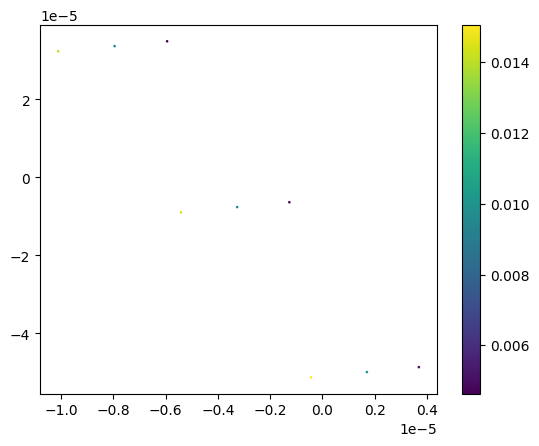

In [58]:
dists = np.linalg.norm(train_x[:,:2], ord=2, axis=1)

# count = 50
# print(np.argsort(dists)[:count])
# small_x = train_x[np.argsort(dists)[:count],:2]
# small_y = train_y[np.argsort(dists)[:count],:2]

index_list = [45394, 45415, 45432, 45438, 45458, 45484, 45331, 45358, 45390]
small_x = train_x[index_list,:2]
small_y = train_y[index_list,:]
print(small_x)
print(small_y)

fig=plt.figure()
ax=fig.add_subplot(111)
sc0 = ax.scatter(small_x[:, 0], small_x[:, 1], c = small_y[:, 0], s = 0.75)

plt.colorbar(sc0)

scale = 0.0001
ax.xlim = [-scale,scale]
ax.ylim = [-scale,scale]

plt.show()

In [95]:
def area_Voronoi(origin, neighbors): # Neighbors listed in counterclockwise order!
    area = 0.0
    total_area = 0.0
    for neighbor, idx in zip(neighbors, range(0, len(neighbors))):
        counter_clock_n = neighbors[(idx+1) % len(neighbors)]
        # counter_clock_n = (idx+len(neighbors)-1) % len(neighbors)
        # alpha_ij = angle_between(neighbor-neighbors[clock_n], origin-neighbors[clock_n])
        # beta_ij = angle_between(neighbor-neighbors[counter_clock_n], origin-neighbors[counter_clock_n])
        # dist_sq = np.linalg.norm(origin - neighbor,ord=2)**2
        ang_P = angle_between(neighbor-origin, counter_clock_n-origin)
        ang_Q = angle_between(origin-neighbor, counter_clock_n-neighbor)
        # ang_R = angle_between(clock_n-neighbor, clock_n-origin)
        ang_R = np.pi - ang_P - ang_Q

        PQ = np.linalg.norm(origin-neighbor, ord=2)
        PR = np.linalg.norm(origin-counter_clock_n, ord=2)

        # If all angles are acute, can use Voronoi area
        if max(ang_P, ang_Q, ang_R) < np.pi/2:
            a = ((PR**2)/np.tan(ang_Q) + (PQ**2)/np.tan(ang_Q))/8
            area += a
        else: # There is an obtuse angle
            T = PQ*PR*np.sin(ang_P)
            total_area += T
            # Determine if angle at origin is obtuse, add accordingly
            if ang_P > np.pi/2:
                area += T/2
            else:
                area += T/4
    return area

def area_barycentric(origin, neighbors): # Neighbors listed in counterclockwise order!
    area = 0.0
    total_angle = 0.0
    for neighbor, idx in zip(neighbors, range(0, len(neighbors))):
        counter_clock_n = neighbors[(idx+1) % len(neighbors)]
        ang_P = angle_between(neighbor-origin, counter_clock_n-origin)
        total_angle += ang_P
        # ang_Q = angle_between(origin-neighbor, counter_clock_n-neighbor)
        # # ang_R = angle_between(clock_n-neighbor, clock_n-origin)
        # ang_R = np.pi - ang_P - ang_Q

        PQ = np.linalg.norm(origin-neighbor, ord=2)
        PR = np.linalg.norm(origin-counter_clock_n, ord=2)

        T = PQ*PR*np.sin(ang_P)
        area += T/3
    return area

# Calculate mean curvature normal for a point and its 1-ring neighbors (listed counterclockwise)
def mean_curvature_normal(origin, neighbors):
    mixed_area = area_Voronoi(origin, neighbors)
    # mixed_area = area_barycentric(origin, neighbors)

    output = np.zeros_like(origin)
    for neighbor, idx in zip(neighbors, range(0, len(neighbors))):
        counter_clock_n = neighbors[(idx+1) % len(neighbors)]
        clock_n = neighbors[(idx+len(neighbors)-1) % len(neighbors)]
        alpha_ij = angle_between(neighbor-clock_n, origin-clock_n)
        beta_ij = angle_between(neighbor-counter_clock_n, origin-counter_clock_n)
        output += (1/np.tan(alpha_ij) + 1/np.tan(beta_ij))*(origin - neighbor)
    output /= (2*mixed_area)
    # output /= np.linalg.norm(output, ord=2)

    return output

In [97]:

import plotly.graph_objects as go

focus = 0

origin = np.hstack([small_x[1], small_y[1,focus]])
print(origin)

neighbors = np.hstack([small_x[0], small_y[0,focus]])
for i in [3,4,5,2,8,7,6]:
    neighbors = np.vstack([neighbors, np.hstack([small_x[i], small_y[i,0]])])

neighbors

area = area_Voronoi(origin, neighbors)
print(area)
area = area_barycentric(origin, neighbors)
print(area)
K = mean_curvature_normal(origin, neighbors)
print(K)
# K = K / np.linalg.norm(K)

print(K[0:2] / K[2])

# norm = K / np.linalg.norm(K, ord=2)
# print(norm)

# fig = go.Figure(data=[go.Mesh3d(x=small_x[:,0], y=small_x[:,1], z=small_y[:,focus], color='lightpink', opacity=0.50)])
# fig.show()

[-3.26154259e-06 -7.59439490e-06  9.56382975e-03]
5.14450786244907e-07
5.487995059277721e-07
[-3.06903984e+01 -3.64963602e+00 -1.39675872e-02]
[2197.25841596  261.29323379]


In [50]:

fig = go.Figure(data=[go.Mesh3d(x=small_x[:,0], y=small_x[:,1], z=small_y[:,focus], color='lightpink', opacity=0.50)])
fig.show()